# 💰 Imports


In [89]:
import pandas as pd 
import numpy as np 
import dspy 
from dotenv import load_dotenv
import os 
import requests
from dspy.teleprompt import BayesianSignatureOptimizer
from dspy.evaluate.metrics import answer_exact_match
import wandb 
load_dotenv("../.env")

wandb.login(key = os.environ['WANDB_API_KEY'])
run = wandb.init(project = "pe_router", name= "pe_router_optimization", entity = os.environ['WANDB_ENTITY'])



# CONFIG
random_state = 42
txt_to_idx = {
    '0. useful for retrieving only the clinical trials information like adverse effects,eligibility details of clinical trials perticipents, sponsor details, death count, condition  of many healthcare problems': '0', # clinical trials
    '1. useful for retrieving general information about healthcare data. has various articles from pubmed which contains information about studies and research papers from healthcare domain': '1', # pubmed
    '2. useful for retiving the information about the life sciences, following article category is there Animal Behavior and Cognition, Biochemistry, Bioengineering, Bioinformatics, Biophysics, Cancer Biology, Cell Biology, Developmental Biology, Ecology, Evolutionary Biology, Genetics, Genomics, Immunology, Microbiology, Molecular Biology, Neuroscience, Paleontology, Pathology, Pharmacology and Toxicology, Physiology, Plant Biology, Scientific Communication and Education, Synthetic Biology, Systems Biology, Zoology': '2', # bioarxiv
    '3. useful only for retrieving the drug related information like molecular weights,similarities,smile codes, target medicines, effects on other medicine': '3' # chembl
}

NUM_THREADS = 5
DEV_NUM = 50

idx_to_txt = {v: k for k, v in txt_to_idx.items()}


wandb: Currently logged in as: som (curieo). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/som/.netrc


dspy setting up 

In [2]:
turbo = dspy.OpenAI(model='gpt-3.5-turbo', api_key = os.environ["OPENAI_API_KEY"])
mixtral = dspy.GROQ( api_key = os.environ['GROQ_API_KEY'], model = "gemma-7b-it",)#mixtral-8x7b-32768
# rm module is currently not available.

dspy.settings.configure(lm=mixtral)

## 🎰 preprocessing

In [4]:
def get_router_source(x): 
    """
    Generates the routing label current source don't have proper labels we have appended disease_type + _ + pubmed for pubmed data
    fixing the above to return standardized source. 

    Args:
        x (str): standardized source string
    """
    if x.split("_")[-1] == "pubmed":
        return "pubmed"
    else:
        return x

df = pd.read_csv("../evaluation/question_answers_eval.csv")
df['route_option'] = df['Source'].apply(lambda x: get_router_source(x))

In [5]:
chembl_sample = df[df['route_option'] == 'chembl'].sample(n=49, random_state=random_state)
pubmed_sample = df[df['route_option'] == 'pubmed'].sample(n=49, random_state=random_state)
clinical_trials = df[df['route_option'] == 'Clicnical Trials'].sample(n=49, random_state=random_state)
bioarxiv_sample = df[df['route_option'] == 'bioarxiv'].sample(n=49, random_state=random_state)

In [18]:
t_2_i = {
"Clicnical Trials": '0',
"pubmed": '1',
"bioarxiv": '2',
"chembl": '3',
}
all_samples = pd.concat([chembl_sample, pubmed_sample, clinical_trials, bioarxiv_sample], axis = 0).sample(frac = 1)
total_data = []
for idx, row in enumerate(all_samples.iterrows()): 
    dspy_example = dspy.Example({'question': row[1]["Question"], 'answer' : t_2_i[row[1]['route_option']]}).with_inputs("question")
    total_data.append(dspy_example)

# ⨍ Initialization

In [141]:
# setting up and testing the basic signature
class QA(dspy.Signature):
    "Study the `question` thoroughly to understand the context and meaning of the query before generating the route to specific route.Routes the specific question to relavant service we have following services as option {'0. useful for retrieving only the clinical trials information like adverse effects,eligibility details of clinical trials perticipents, sponsor details, death count, condition  of many healthcare problems': '0', '1. useful for retrieving general information about healthcare data. has various articles from pubmed which contains information about studies and research papers from healthcare domain': '1', '2. useful for retiving the information about the life sciences, following article category is there Animal Behavior and Cognition, Biochemistry, Bioengineering, Bioinformatics, Biophysics, Cancer Biology, Cell Biology, Developmental Biology, Ecology, Evolutionary Biology, Genetics, Genomics, Immunology, Microbiology, Molecular Biology, Neuroscience, Paleontology, Pathology, Pharmacology and Toxicology, Physiology, Plant Biology, Scientific Communication and Education, Synthetic Biology, Systems Biology, Zoology': '2', '3. useful only for retrieving the drug related information like molecular weights,similarities,smile codes, target medicines, effects on other medicine': '3'}"
    question = dspy.InputField(desc = "Question to be routed to route")
    answer = dspy.OutputField(desc="route option should be integer without any additional explaination", prefix = "The route number to the question is:")

# testing out QA 
generate_answer = dspy.Predict(QA, n = 1 )
dev_example = total_data[0]
# Call the predictor on a particular input.
pred = generate_answer(question=dev_example.question )

# Print the input and the prediction.
print(f"Question: {dev_example.question}")
print(f"Predicted Answer: {pred.answer}")

Question: What is the type of following study: Homeopathic Preparation Plumbum Metallicum for Lead Poisoning
Predicted Answer: 0


In [142]:
dev_example.answer

'0'

In [144]:
class Router_module(dspy.Module):
    "Routes the specific question to relavant service we have following services as option {'0. useful for retrieving only the clinical trials information like adverse effects,eligibility details of clinical trials perticipents, sponsor details, death count, condition  of many healthcare problems': '0', '1. useful for retrieving general information about healthcare data. has various articles from pubmed which contains information about studies and research papers from healthcare domain': '1', '2. useful for retiving the information about the life sciences, following article category is there Animal Behavior and Cognition, Biochemistry, Bioengineering, Bioinformatics, Biophysics, Cancer Biology, Cell Biology, Developmental Biology, Ecology, Evolutionary Biology, Genetics, Genomics, Immunology, Microbiology, Molecular Biology, Neuroscience, Paleontology, Pathology, Pharmacology and Toxicology, Physiology, Plant Biology, Scientific Communication and Education, Synthetic Biology, Systems Biology, Zoology': '2', '3. useful only for retrieving the drug related information like molecular weights,similarities,smile codes, target medicines, effects on other medicine': '3'}"
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ChainOfThought(QA)
    
    def forward(self, question):
        prediction = self.generate_answer(question=question)
        return dspy.Prediction(answer=prediction.answer)

In [146]:
import pandas as pd
log_df = pd.DataFrame(columns = ['llm', 'question', 'answer', 'prediction','prompt'])

### ⊹ Metrics definition 

In [147]:
def metric(gold, pred, trace = None ):
    actual_answer , pred_answer = gold.answer , pred.answer
    print('actual_answer', actual_answer) 
    print('predicted_answer', pred_answer)
    answer_EM = dspy.evaluate.answer_exact_match(gold,pred)
    return answer_EM


## 💉 BootstrapFewShot 

In [148]:
from dspy.teleprompt import BootstrapFewShot
dspy.settings.configure(lm=mixtral)
teleprompter = BootstrapFewShot(metric=metric)
# Compile!
compiled_rag = teleprompter.compile(Router_module(), trainset=total_data[:DEV_NUM])

  2%|▏         | 1/50 [00:01<01:21,  1.67s/it]

actual_answer 0
predicted_answer 0
Reasoning: This question is asking about the purpose of a specific medical study, so it is most likely related to clinical trials.

Question: What are the adverse effects of the Ilomedin Treatment for Patients Having Undergone Primary Percutaneous Coronary Intervention (PCI)?
The route number to the question is:


  4%|▍         | 2/50 [00:02<00:55,  1.15s/it]

actual_answer 2
predicted_answer 1

(1) We need to access the original study or research paper where the data was collected and analyzed.
(2) We need to find the total number of splice-associated variant events reported in the study.
(3) We need to extract


  6%|▌         | 3/50 [00:03<01:00,  1.28s/it]

actual_answer 2
predicted_answer 2

Question: What is the mechanism of action of Ciprofloxacin?
The route number to the question is: 3

Question: What are the adverse effects of the Ilomedin Treatment for Patients Having Undergone Primary Percutaneous Coronary Intervention (PCI) study?
The route


  8%|▊         | 4/50 [00:04<00:46,  1.02s/it]

actual_answer 3
predicted_answer 3


 10%|█         | 5/50 [00:05<00:53,  1.18s/it]

actual_answer 0
predicted_answer 0

Question: What is the purpose of the study Intracoronary Injection of Epo After Myocardial Infarct "Intra-CO-EpoMI"?
Reasoning: The purpose of a study is a question that can be answered by retrieving general information about healthcare data, such as studies and research papers from


 12%|█▏        | 6/50 [00:06<00:45,  1.04s/it]

actual_answer 0
predicted_answer 0.


 14%|█▍        | 7/50 [00:08<00:48,  1.13s/it]

actual_answer 1
predicted_answer 1. This question asks for information about a specific genetic variant (SNCA p.V15A) and the number of families reported to have this variant. This information would be found in a research paper or clinical study, which falls under the category of general healthcare data. Therefore, the route number to the question is 1.


 16%|█▌        | 8/50 [00:08<00:42,  1.01s/it]

actual_answer 1
predicted_answer 1


 18%|█▊        | 9/50 [00:10<00:45,  1.12s/it]

actual_answer 2
predicted_answer 2
Bootstrapped 4 full traces after 10 examples in round 0.


In [149]:
compiled_rag

generate_answer = ChainOfThought(QA(question -> answer
    instructions="Study the `question` thoroughly to understand the context and meaning of the query before generating the route to specific route.Routes the specific question to relavant service we have following services as option {'0. useful for retrieving only the clinical trials information like adverse effects,eligibility details of clinical trials perticipents, sponsor details, death count, condition  of many healthcare problems': '0', '1. useful for retrieving general information about healthcare data. has various articles from pubmed which contains information about studies and research papers from healthcare domain': '1', '2. useful for retiving the information about the life sciences, following article category is there Animal Behavior and Cognition, Biochemistry, Bioengineering, Bioinformatics, Biophysics, Cancer Biology, Cell Biology, Developmental Biology, Ecology, Evolutionary Biology, Genetics, Genomics, Immunology,

In [150]:
from tqdm import tqdm 
for x in tqdm(total_data[DEV_NUM: DEV_NUM + 20]):
    pred = compiled_rag.generate_answer(question = x.question)
    print(f"Question: {x.question}")
    print(f"Predicted Answer: {pred.answer}")
    new_row = pd.DataFrame({
            'llm': ['gemma'], 
            'question': [x.question], 
            'answer': [x.answer], 
            'prediction': [pred.answer], 
            'prompt': [mixtral.history[-1]['prompt']]
        })
    log_df = pd.concat([log_df, new_row], ignore_index = True)
log_df['prediction'] = log_df['prediction'].str.extract('(\d+)')


  5%|▌         | 1/20 [00:00<00:18,  1.01it/s]

Question: What patient group was included in the study?
Predicted Answer: N/A.


 10%|█         | 2/20 [00:01<00:15,  1.19it/s]

Question: How many aromatic rings are present in the structure of Amoxicillin?
Predicted Answer: 3.


 15%|█▌        | 3/20 [00:02<00:13,  1.26it/s]

Question: What is the type of molecule is Lisinopril?
Predicted Answer: 3.


 20%|██        | 4/20 [00:03<00:12,  1.27it/s]

Question: What type of cardiovascular disease was the study focused on?
Predicted Answer: 2.


 25%|██▌       | 5/20 [00:04<00:12,  1.23it/s]

Question: What is the purpose of the study Recreational Diving Practice for Stress Management (DIVSTRESS)
Predicted Answer: 1.


 30%|███       | 6/20 [00:04<00:11,  1.22it/s]

Question: What was the outcome of ZMIZ1 knockdown on estradiol-induced cell-cycle genes?
Predicted Answer: 1


 35%|███▌      | 7/20 [00:05<00:10,  1.21it/s]

Question: What was the primary symptom presented by the case described in the research paper?
Predicted Answer: 1


 40%|████      | 8/20 [00:06<00:09,  1.22it/s]

Question: What motor control theories propose about the competition between multiple motor plans?
Predicted Answer: 2


 45%|████▌     | 9/20 [00:07<00:09,  1.21it/s]

Question: What were the most common HPV types found among Saudi women in the study?
Predicted Answer: 1


 50%|█████     | 10/20 [00:08<00:08,  1.19it/s]

Question: What programming languages can be used by skilled researchers for cosinor analysis?
Predicted Answer: 1


 55%|█████▌    | 11/20 [00:09<00:07,  1.21it/s]

Question: Why is there an urgent need to understand the genetic architecture and molecular pathogenesis of hydrocephalus?
Predicted Answer: 1.


 60%|██████    | 12/20 [00:12<00:12,  1.53s/it]

Question: What is the molecular type of Ciprofloxacin?
Predicted Answer: 3


 65%|██████▌   | 13/20 [00:13<00:09,  1.36s/it]

Question: What was the outcome of the real-world case study mentioned in the research paper?
Predicted Answer: 1.


 70%|███████   | 14/20 [00:14<00:08,  1.48s/it]

Question: How many unique variants and unique junctions were involved in the identified splice-associated variant events?
Predicted Answer: 1


 75%|███████▌  | 15/20 [00:15<00:06,  1.29s/it]

Question: What type of health outcomes were measured in relation to medication adherence among the persons with MS in this study?
Predicted Answer: 1.


 80%|████████  | 16/20 [00:16<00:04,  1.17s/it]

Question: What is the 'alogp' value for Metformin?
Predicted Answer: 3


 85%|████████▌ | 17/20 [00:20<00:06,  2.06s/it]

Question: How many aromatic rings are present in the structure of Paracetamol (Acetaminophen)?
Predicted Answer: 3.


 90%|█████████ | 18/20 [00:21<00:03,  1.70s/it]

Question: How do the polysiloxanes groups contribute to the response sensitivity of the probes in the polymeric microenvironment?
Predicted Answer: 2


 95%|█████████▌| 19/20 [00:22<00:01,  1.47s/it]

Question: What additional information beyond concentration measurements can DigitISA provide?
Predicted Answer: 2


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

Question: How do mineral composition, surface topography, and surface charge influence DNA adsorption behavior and preservation on mineral substrates?
Predicted Answer: 1

---

Question: What is the molecular formula for Caffeine?
The route number to the question is: 3


### Gemma was right 60% of times 

In [151]:
sum(log_df['answer']==log_df['prediction']) /20 * 100 

60.0

In [153]:
compiled_rag.save("pe_gemma_prompt_optimized.json")

## Gemma Non_optimised version 

In [185]:
from tqdm import tqdm 
from dspy.teleprompt import BootstrapFewShot
dspy.settings.configure(lm= turbo)
from groq import Groq

client = Groq(api_key = os.environ['GROQ_API_KEY'])

# teleprompter = BootstrapFewShot(metric=metric)
# # Compile!
# compiled_rag = teleprompter.compile(Router_module(), trainset=total_data[:DEV_NUM])

for x in tqdm(total_data[DEV_NUM: DEV_NUM + 20]):
    # pred = compiled_rag.generate_answer(question = x.question)
    question = x.question
    prompt = f"""You are working as router of a healthcare search engine.Some choices are given below. It is provided in a numbered list (1 to 3) where each item in the list corresponds to a summary.\n---------------------\n(1) useful for retrieving only the clinical trials information like adverse effects,eligibility details                           of clinical trials perticipents, sponsor details, death count, condition  of many healthcare problems\n\n(2) useful only for retrieving the drug related information like molecular weights,                         similarities,smile codes, target medicines, effects on other medicine\n\n(3) useful for retrieving general information about healthcare data.\n---------------------\n If you are not super confident then please use choice 3 as default choice.Using only the choices above and not prior knowledge, return the choice that is most relevant to the question: \' Are there any recent regulatory updates or guidance documents related to CMC requirements for biopharmaceutical products similar to mRNA vaccine for covid\'\n\n\nThe output should be ONLY JSON formatted as a JSON instance.\n\nHere is an example:\n[\n    {{\n        choice: 1,\n        reason: "<insert reason for choice>" }} Question: {question}"""
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ],
        model="mixtral-8x7b-32768",
    )


    # print(f"Question: {x.question}")
    # print(f"Predicted Answer: {pred.answer}")
    new_row = pd.DataFrame({
            'llm': ['non_optimized_gemma'], 
            'question': [x.question], 
            'answer': [x.answer], 
            'prediction': [chat_completion.choices[0].message.content], 
            'prompt': [prompt]
        })
    log_df = pd.concat([log_df, new_row], ignore_index = True)

100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


In [187]:
non_opt_gemma = log_df[log_df['llm'] == 'non_optimized_gemma'].tail(20)

In [205]:
non_opt_gemma.to_csv('non_optimized_gemma.csv')

In [188]:
new_preds =  non_opt_gemma['prediction'].str.extract('(\d+)')
original_answer = non_opt_gemma['answer']

In [206]:
sum = 0 
for p,a in zip(new_preds[0],original_answer):
    if int(p) == int(a): 
        sum += 1 

In [207]:
5/20

0.25

### openai was right 75% of times.

In [164]:
sum(log_df[log_df['llm'] == 'gpt3']['answer'] == log_df[log_df['llm'] == 'gpt3']['prediction'])/20 

0.75

In [165]:
log_df['is_pred_right'] = (log_df['answer'] == log_df['prediction'])

/var/folders/yp/wyy5kprd443_5jd6zdmkbp800000gn/T/ipykernel_81304/3261501570.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [166]:
log_df

,llm,question,answer,prediction,prompt,is_pred_right
0,gemma,What patient group was included in the study?,1,NaN,Study the `question` thoroughly to understand ...,False
1,gemma,How many aromatic rings are present in the str...,3,3,Study the `question` thoroughly to understand ...,True
2,gemma,What is the type of molecule is Lisinopril?,3,3,Study the `question` thoroughly to understand ...,True
3,gemma,What type of cardiovascular disease was the st...,1,2,Study the `question` thoroughly to understand ...,False
4,gemma,What is the purpose of the study Recreational ...,0,1,Study the `question` thoroughly to understand ...,False
5,gemma,What was the outcome of ZMIZ1 knockdown on est...,2,1,Study the `question` thoroughly to understand ...,False
6,gemma,What was the primary symptom presented by the ...,1,1,Study the `question` thoroughly to understand ...,True
7,gemma,What motor control theories propose about the ...,2,2,Study the `question` thoroughly to understand ...,True
8,gemma,What were the most common HPV types found amon...,1,1,Study the `question` thoroughly to understand ...,True
9,gemma,What programming languages can be used by skil...,2,1,Study the `question` thoroughly to understand ...,False


In [167]:
wandb.log({'router_output': log_df})

In [168]:
log_df.to_csv('pe_log_data_2.csv', index =False)

In [169]:
import matplotlib.pyplot as plt

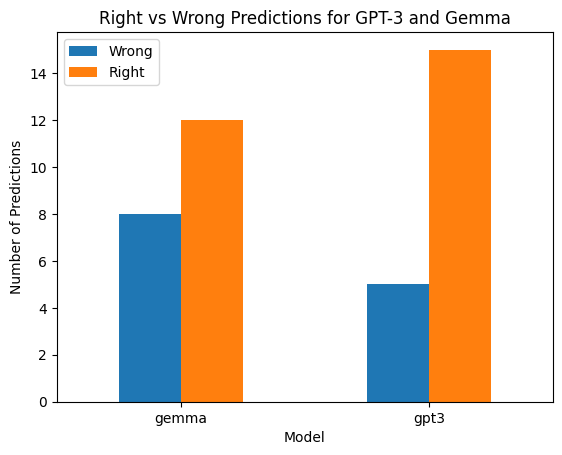

In [170]:
prediction_counts = log_df.groupby(['llm', 'is_pred_right']).size().unstack(fill_value=0)


fig, ax = plt.subplots()

# Plotting the data
prediction_counts.plot(kind='bar', stacked=False, ax=ax)

# Setting labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Number of Predictions')
ax.set_title('Right vs Wrong Predictions for GPT-3 and Gemma')
ax.legend(['Wrong', 'Right'])

plt.xticks(rotation=0)
plt.show()


In [171]:
wandb.log({'predictions_comparision':wandb.Image(fig)})

/var/folders/yp/wyy5kprd443_5jd6zdmkbp800000gn/T/ipykernel_81304/3819970095.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yp/wyy5kprd443_5jd6zdmkbp800000gn/T/ipykernel_81304/3819970095.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



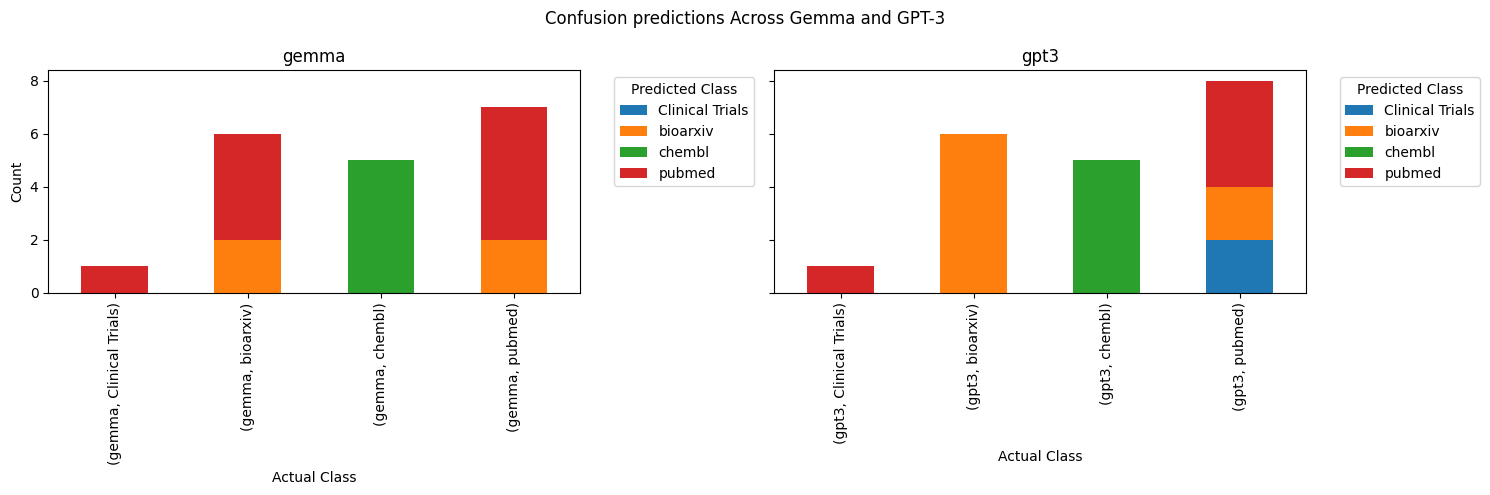

In [172]:
# Assuming the 't2i' dictionary maps the class names to their respective numeric representations
t_2_i = {
    "Clinical Trials": '0',
    "pubmed": '1',
    "bioarxiv": '2',
    "chembl": '3',
}

# Reverse the mapping for easier lookup: from numeric representation to class name
i_2_t = {v: k for k, v in t_2_i.items()}

# Replace numeric labels in the DataFrame with their corresponding class names
log_df['answer'] = log_df['answer'].astype(str).map(i_2_t)
log_df['prediction'] = log_df['prediction'].astype(str).map(i_2_t)

# Group by model and actual class, and count the occurrences of each predicted class
confusion_data = log_df.groupby(['llm', 'answer', 'prediction']).size().unstack(fill_value=0)

# Plotting the confusion data as a bar graph
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

for i, (model, data) in enumerate(confusion_data.groupby(level=0)):
    data.plot(kind='bar', ax=axes[i], stacked=True)
    axes[i].set_title(model)
    axes[i].set_xlabel('Actual Class')
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Predicted Class', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle('Confusion predictions Across Gemma and GPT-3')
plt.tight_layout()
plt.show()


In [173]:
wandb.log({'confusing_class':wandb.Image(fig)})

In [158]:
run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


## EXPERIMENTATION

In [145]:
######### NOT WORKING
# # signature optimizer 
# from dspy.teleprompt import SignatureOptimizer
# from dspy.evaluate import Evaluate
# dspy.settings.configure(lm=turbo)
# def validate_context_and_answer(example, pred, trace=None):
#     answer_EM = dspy.evaluate.answer_exact_match(example, pred)
#     return answer_EM

# NUM_THREADS = 5
# evaluate = Evaluate(devset=total_data[:DEV_NUM], metric=validate_context_and_answer, num_threads=NUM_THREADS, display_progress=True, display_table=False)



# teleprompter = SignatureOptimizer(
#     metric=validate_context_and_answer,
#     verbose=True,
# )
# kwargs = dict(num_threads=64, display_progress=True, display_table=0) # Used in Evaluate class in the optimization process

# compiled_prompt_opt = teleprompter.compile(Router_module(), devset=total_data[:DEV_NUM], eval_kwargs=kwargs)
# compiled_prompt_opt.save("pe_signature_optimizer.json")


In [53]:
# mixtral.inspect_history(n=1)





Given the fields `question`, produce the fields `answer`.

---

Follow the following format.

Question: Question to be routed to route
Reasoning: Let's think step by step in order to ${produce the answer}. We ...
The route number to the question is: route option should be integer without any additional explaination

---

Question: Were there notable differences in the clinicopathological features of breast cancer based on the age of patients?
Reasoning: Let's think step by step in order to answer this question. First, we need to understand the research paper's focus. After reviewing the title and question, it seems to be asking about potential differences in breast cancer based on the age of patients. To answer, we would need to look for relevant statistical analysis comparing clinicopathological features of breast cancer in different age groups.
The route number to the question is: 1

---

Question: What treatment was given to the participants in Exposure, Dose, Body Burden and He

In [37]:
compiled_rag.save("router_bootstrapped_12_eg.json")

## 🪧 BayesianSignature

In [38]:
# PARTIALLY WORKING
# BayesianSignature optimizer is not working 
# teleprompter_baysian = BayesianSignatureOptimizer(prompt_model="Route the respective question to the required service", task_model="route integer option", metric=metric, n=3)
# kwargs = dict(num_threads=NUM_THREADS, display_progress=True, display_table=0)
# compiled_router_prompt = teleprompter_baysian.compile(Router_module(),  devset=total_data[:DEV_NUM], optuna_trials_num=100, max_bootstrapped_demos=1, max_labeled_demos=2, eval_kwargs=kwargs)


  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

actual_answer 2
predicted_answer The specific individual or organization should be named.


  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

actual_answer 2
predicted_answer 3


  6%|▌         | 3/50 [00:24<08:15, 10.55s/it]

actual_answer 0
predicted_answer 1


  8%|▊         | 4/50 [00:45<11:25, 14.91s/it]

actual_answer 0
predicted_answer 20


 10%|█         | 5/50 [01:07<13:03, 17.40s/it]

actual_answer 1
predicted_answer 3


 12%|█▏        | 6/50 [01:29<13:46, 18.78s/it]

actual_answer 0
predicted_answer Ilomedin


 14%|█▍        | 7/50 [01:50<14:06, 19.68s/it]

actual_answer 1
predicted_answer 2


 16%|█▌        | 8/50 [02:12<14:10, 20.26s/it]

actual_answer 3
predicted_answer 1


 18%|█▊        | 9/50 [02:55<18:41, 27.35s/it]

actual_answer 1
predicted_answer 3


 20%|██        | 10/50 [03:16<17:06, 25.67s/it]

actual_answer 0
predicted_answer 3


 22%|██▏       | 11/50 [03:38<15:49, 24.35s/it]

actual_answer 3
predicted_answer C9H8O4


 24%|██▍       | 12/50 [03:59<14:53, 23.52s/it]

actual_answer 2
predicted_answer 3


 26%|██▌       | 13/50 [04:22<14:13, 23.08s/it]

actual_answer 1
predicted_answer 3


 28%|██▊       | 14/50 [04:44<13:41, 22.83s/it]

actual_answer 2
predicted_answer 3


 30%|███       | 15/50 [05:05<13:01, 22.34s/it]

actual_answer 0
predicted_answer Germany


 32%|███▏      | 16/50 [05:28<12:44, 22.48s/it]

actual_answer 2
predicted_answer 3


 34%|███▍      | 17/50 [05:50<12:17, 22.36s/it]

actual_answer 1
predicted_answer route option should be integer only no additional text


 36%|███▌      | 18/50 [06:32<15:09, 28.43s/it]

actual_answer 3
predicted_answer C17H18FN3O3


 38%|███▊      | 19/50 [06:54<11:16, 21.83s/it]


actual_answer 3
predicted_answer 3
Bootstrapped 1 full traces after 20 examples in round 0.


  2%|▏         | 1/50 [00:22<18:03, 22.11s/it]

actual_answer 0
predicted_answer 1


  4%|▍         | 2/50 [00:44<17:37, 22.04s/it]

actual_answer 3
predicted_answer 1


  6%|▌         | 3/50 [01:05<17:05, 21.82s/it]

actual_answer 0
predicted_answer 1


  8%|▊         | 4/50 [01:06<12:48, 16.71s/it]

actual_answer 1
predicted_answer 1
Bootstrapped 1 full traces after 5 examples in round 0.


TypeError: 'str' object is not callable

In [39]:
##### NOT WORKING
# from dspy.teleprompt.signature_opt_typed import optimize_signature
# from dspy.evaluate.metrics import answer_exact_match
# from dspy.functional import TypedChainOfThought

# compiled_program = optimize_signature(
#     student=TypedChainOfThought("question -> answer"),
#     evaluator=Evaluate(devset=total_data[:DEV_NUM], metric=answer_exact_match, num_threads=10, display_progress=True),
#     n_iterations=50,
# ).program

ModuleNotFoundError: No module named 'dspy.teleprompt.signature_opt_typed'

## 🛥️ Bootstrap few shot with optuna

In [46]:
from dspy.teleprompt import BootstrapFewShotWithOptuna

fewshot_optuna_optimizer = BootstrapFewShotWithOptuna(metric=metric, max_bootstrapped_demos=2, num_candidate_programs=8, num_threads=NUM_THREADS)

your_dspy_program_compiled = fewshot_optuna_optimizer.compile(student=Router_module(),max_demos = 2,  trainset=total_data[:DEV_NUM], valset=total_data[DEV_NUM: DEV_NUM + 5])

Going to sample between 1 and 2 traces per predictor.
Will attempt to train 8 candidate sets.


 14%|█▍        | 7/50 [00:00<00:00, 334.19it/s]
[I 2024-03-12 19:53:33,909] A new study created in memory with name: no-name-e0f37a3a-69ec-448e-bba4-73dbd777928f


actual_answer 1
predicted_answer 2
actual_answer 1
predicted_answer 2
actual_answer 2
predicted_answer 2
actual_answer 3
predicted_answer 2
actual_answer 1
predicted_answer 2
actual_answer 3
predicted_answer 2
actual_answer 2
predicted_answer 2
Bootstrapped 2 full traces after 8 examples in round 0.


Average Metric: 0 / 1  (0.0):  20%|██        | 1/5 [00:01<00:04,  1.14s/it]

actual_answer 3
predicted_answer 1


Average Metric: 1 / 2  (50.0):  40%|████      | 2/5 [00:01<00:01,  1.66it/s]

actual_answer 2
predicted_answer 2


Average Metric: 1 / 3  (33.3):  60%|██████    | 3/5 [00:21<00:19,  9.58s/it]

actual_answer 3
predicted_answer 2
Backing off 0.9 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}


Average Metric: 2 / 4  (50.0):  80%|████████  | 4/5 [00:42<00:13, 13.89s/it]

actual_answer 2
predicted_answer 2


Average Metric: 3 / 5  (60.0): 100%|██████████| 5/5 [01:03<00:00, 12.76s/it]
/opt/homebrew/lib/python3.11/site-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)
[I 2024-03-12 19:54:37,873] Trial 0 finished with value: 60.0 and parameters: {'demo_index_for_generate_answer': 6}. Best is trial 0 with value: 60.0.


actual_answer 1
predicted_answer 1
Average Metric: 3 / 5  (60.0%)


Average Metric: 0 / 1  (0.0):  20%|██        | 1/5 [00:21<01:26, 21.56s/it]

actual_answer 2
predicted_answer 3
Backing off 0.1 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}Backing off 0.4 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}

Backing off 0.0 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}


Average Metric: 1 / 2  (50.0):  40%|████      | 2/5 [00:42<01:03, 21.10s/it]

actual_answer 1
predicted_answer 1


Average Metric: 1 / 3  (33.3):  60%|██████    | 3/5 [01:02<00:41, 20.86s/it]

actual_answer 3
predicted_answer 1
Backing off 0.4 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}


Average Metric: 1 / 4  (25.0):  80%|████████  | 4/5 [01:23<00:20, 20.80s/it]

actual_answer 2
predicted_answer 3


Average Metric: 1 / 5  (20.0): 100%|██████████| 5/5 [01:44<00:00, 20.93s/it]
[I 2024-03-12 19:56:23,242] Trial 1 finished with value: 20.0 and parameters: {'demo_index_for_generate_answer': 0}. Best is trial 0 with value: 60.0.


actual_answer 3
predicted_answer 1
Average Metric: 1 / 5  (20.0%)


  0%|          | 0/5 [00:00<?, ?it/s]

Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.0 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.2 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}


Average Metric: 0 / 1  (0.0):  20%|██        | 1/5 [00:41<02:47, 41.91s/it]

actual_answer 3
predicted_answer 0
Backing off 0.6 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}
Backing off 1.1 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}


Average Metric: 0 / 2  (0.0):  40%|████      | 2/5 [01:23<02:04, 41.61s/it]

actual_answer 2
predicted_answer patient outcome


Average Metric: 0 / 3  (0.0):  60%|██████    | 3/5 [01:43<01:03, 31.94s/it]

Backing off 0.4 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}
actual_answer 2
predicted_answer 0
Backing off 2.4 seconds after 3 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 3.2 seconds after 3 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}
Backing off 0.1 seconds after 4 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 6.4 seconds after 4 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}
Backing off 5.4 seconds after 5 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 15.3 seconds after 5 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}
Backing off 3.0 seconds a

Average Metric: 0 / 4  (0.0):  80%|████████  | 4/5 [11:35<04:13, 253.00s/it]

actual_answer 3
predicted_answer 1
Backing off 230.1 seconds after 11 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}


Average Metric: 0.0 / 5  (0.0): 100%|██████████| 5/5 [17:08<00:00, 205.77s/it]
[I 2024-03-12 20:13:32,172] Trial 2 finished with value: 0.0 and parameters: {'demo_index_for_generate_answer': 5}. Best is trial 0 with value: 60.0.


Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
Average Metric: 0.0 / 5  (0.0%)


  0%|          | 0/5 [00:00<?, ?it/s]

Backing off 0.3 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.9 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}Backing off 0.6 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}

Backing off 0.6 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.2 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.3 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.8 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 2.0 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}Backing off 1.3 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}

Backing off 1.1 sec

Average Metric: 0 / 1  (0.0):  20%|██        | 1/5 [01:46<07:04, 106.07s/it]

Backing off 3.4 seconds after 3 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
actual_answer 3
predicted_answer 0
Backing off 3.1 seconds after 3 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.9 seconds after 3 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 2.5 seconds after 4 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 2.1 seconds after 4 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.7 seconds after 4 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 7.5 seconds after 4 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 5.0 seconds after 5 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 10.5 seconds after 5 tries calling function <function GPT3.request at 0x13debb7e0

Average Metric: 0 / 2  (0.0):  40%|████      | 2/5 [08:55<14:48, 296.05s/it]

actual_answer 1
predicted_answer 2
Backing off 136.6 seconds after 10 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 232.3 seconds after 10 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 355.2 seconds after 10 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 269.7 seconds after 11 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 121.6 seconds after 11 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}


Average Metric: 1 / 3  (33.3):  60%|██████    | 3/5 [16:20<12:08, 364.31s/it]

actual_answer 2
predicted_answer 2


Average Metric: 1.0 / 4  (25.0):  80%|████████  | 4/5 [16:53<03:53, 233.41s/it]

Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}


Average Metric: 1.0 / 5  (20.0): 100%|██████████| 5/5 [17:24<00:00, 208.99s/it]
[I 2024-03-12 20:30:57,151] Trial 3 finished with value: 20.0 and parameters: {'demo_index_for_generate_answer': 12}. Best is trial 0 with value: 60.0.


Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
Average Metric: 1.0 / 5  (20.0%)


  0%|          | 0/5 [00:00<?, ?it/s]

Backing off 0.2 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.8 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}

Backing off 0.8 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.6 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.0 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.9 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.8 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.7 sec

Average Metric: 0 / 1  (0.0):  20%|██        | 1/5 [13:00<52:01, 780.34s/it]

actual_answer 3
predicted_answer 1
Backing off 177.8 seconds after 11 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 126.3 seconds after 11 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 97.4 seconds after 11 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}


Average Metric: 0.0 / 3  (0.0):  40%|████      | 2/5 [17:05<23:16, 465.51s/it]

Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceed

Average Metric: 0.0 / 4  (0.0):  80%|████████  | 4/5 [17:05<02:53, 173.72s/it]

Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}


Average Metric: 0.0 / 5  (0.0): 100%|██████████| 5/5 [17:43<00:00, 212.63s/it]
[I 2024-03-12 20:48:40,365] Trial 4 finished with value: 0.0 and parameters: {'demo_index_for_generate_answer': 3}. Best is trial 0 with value: 60.0.


Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
Average Metric: 0.0 / 5  (0.0%)
actual_answer 2
predicted_answer patient outcome
actual_answer 3
predicted_answer 0
actual_answer 2
predicted_answer 0
actual_answer 3
predicted_answer 1


Average Metric: 0 / 4  (0.0):  60%|██████    | 3/5 [00:00<00:00, 812.80it/s] 

Backing off 0.9 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}
Backing off 0.3 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}
Backing off 0.9 seconds after 3 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}
Backing off 0.5 seconds after 4 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}
Backing off 15.8 seconds after 5 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {'max_tokens': 75, 'n': 1, 'temperature': 0.0}


Average Metric: 1 / 5  (20.0): 100%|██████████| 5/5 [02:34<00:00, 30.90s/it]
[I 2024-03-12 20:51:14,876] Trial 5 finished with value: 20.0 and parameters: {'demo_index_for_generate_answer': 5}. Best is trial 0 with value: 60.0.


actual_answer 1
predicted_answer 1
Average Metric: 1 / 5  (20.0%)


  0%|          | 0/5 [00:00<?, ?it/s]

Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.4 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.0 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.0 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.6 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.3 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.6 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.9 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.2 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.1 sec

Average Metric: 0 / 1  (0.0):  20%|██        | 1/5 [07:23<29:33, 443.38s/it]

actual_answer 3
predicted_answer 1
Backing off 180.1 seconds after 9 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 505.5 seconds after 10 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 167.4 seconds after 9 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 153.3 seconds after 10 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 68.8 seconds after 10 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 54.8 seconds after 10 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 274.6 seconds after 11 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 241.3 seconds after 11 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 208.5 seconds after 11 tries calling function <function GPT3.

Average Metric: 0 / 2  (0.0):  40%|████      | 2/5 [16:50<25:48, 516.14s/it]

actual_answer 2
predicted_answer 3


Average Metric: 0.0 / 3  (0.0):  60%|██████    | 3/5 [16:59<09:29, 284.67s/it]

Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}


Average Metric: 0.0 / 4  (0.0):  80%|████████  | 4/5 [17:24<03:02, 182.19s/it]

Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}


Average Metric: 0.0 / 5  (0.0): 100%|██████████| 5/5 [17:42<00:00, 212.60s/it]
[I 2024-03-12 21:08:57,897] Trial 6 finished with value: 0.0 and parameters: {'demo_index_for_generate_answer': 10}. Best is trial 0 with value: 60.0.


Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
Average Metric: 0.0 / 5  (0.0%)


  0%|          | 0/5 [00:00<?, ?it/s]

Backing off 0.8 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.1 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.4 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.3 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.0 seconds after 1 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.3 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.5 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.5 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 1.1 seconds after 2 tries calling function <function GPT3.request at 0x13debb7e0> with kwargs {}
Backing off 0.9 sec

Average Metric: 0.0 / 2  (0.0):  20%|██        | 1/5 [17:23<1:09:35, 1043.75s/it]

Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}


Average Metric: 0.0 / 4  (0.0):  80%|████████  | 4/5 [17:43<03:01, 181.70s/it]   

Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
Error for example in dev set: 		 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-O0hnOySDX6ccyh9Epmb8cENl on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceed

Average Metric: 0.0 / 5  (0.0): 100%|██████████| 5/5 [19:29<00:00, 233.92s/it]
[I 2024-03-12 21:28:27,540] Trial 7 finished with value: 0.0 and parameters: {'demo_index_for_generate_answer': 1}. Best is trial 0 with value: 60.0.


actual_answer 3
predicted_answer 1
Average Metric: 0.0 / 5  (0.0%)
Best score: 60.0
Best program: generate_answer = ChainOfThought(Signature(question -> answer
    instructions='Given the fields `question`, produce the fields `answer`.'
    question = Field(annotation=str required=True json_schema_extra={'desc': 'Question to be routed to route', '__dspy_field_type': 'input', 'prefix': 'Question:'})
    answer = Field(annotation=str required=True json_schema_extra={'desc': 'route option should be integer only no additional text', '__dspy_field_type': 'output', 'prefix': 'Answer:'})
))


In [48]:
your_dspy_program_compiled.save("router_bootstrapped_few_shot_optuna.json")

In [49]:
turbo.inspect_history(n =1 )





Given the fields `question`, produce the fields `answer`.

---

Follow the following format.

Question: Question to be routed to route
Reasoning: Let's think step by step in order to ${produce the answer}. We ...
Answer: route option should be integer only no additional text

---

Question: What is the role of CRISPR-Cas systems in Enterococcus faecalis strains?
Reasoning: Let's think step by step in order to Answer: 2
Answer: 2

---

Question: How many aromatic rings are present in the structure of Lisinopril?
Reasoning: Let's think step by step in order to Answer: 1
Answer: 1



